In [1]:
from collections import deque
import random
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from typing import Any
from matplotlib import pyplot as plt
from dataclasses import dataclass, field
from google.colab import drive

In [2]:
class Colors:
    RESET = "\033[0m"
    BLACK = "\u001B[40m"
    RED = "\u001B[41m"
    GREEN = "\u001B[42m"
    YELLOW = "\u001B[43m"
    BLUE = "\u001B[44m"
    PURPLE = "\u001B[45m"
    CYAN = "\u001B[46m"
    WHITE = "\u001B[47m"

In [3]:
@dataclass
class Environment:
    x: float
    y: float
    n: float
    m: float
    dizzy_state: int = field(init=False, default=0)
    mistake_probability: float = 0.9
    dizzy_state_duration: int = 25
    grid: np.ndarray = field(init=False)
    """
        cell types in the grid
        5: player
        0: empty cell
        1: obstacle
        9: target
    """

    def __post_init__(self):
        self.init_grid()

    def init_grid(self):
        self.grid = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],
            [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1],
            [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
            [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 9, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            ])

    def reset(self):
        self.x = 10
        self.y = 1
        self.init_grid()
        return [self.y, self.x]

    def get_available_actions(self):
        """
            the actions in the environment are:
              0: to move right
              1: to move left
              2: to move up
              3: to move down
        """
        return 0, 1, 2, 3

    def calculate_reward(self, y, x): #
        if self.grid[y][x] == 9:
            return 50
        if self.grid[y][x] == 1:
            return -10
        return -1

    # def calculate_reward(self, y, x): #
    #     if self.dizzy_state == 0 and self.grid[y][x] == 9:
    #         return 50
    #     if self.dizzy_state != 0 and self.grid[y][x] == 9:
    #         return 50

    #     if self.dizzy_state == 0 and self.grid[y][x] == 1:
    #         return -50
    #     if self.dizzy_state != 0 and self.grid[y][x] == 1:
    #         return -20

    #     if self.dizzy_state == 0 and self.grid[y][x] == 0:
    #         return -1

        # if self.dizzy_state != 0 and self.grid[y][x] == 0:
        #     return -10

        return 0

    def add_noise_on_action(self, action):
        if self.dizzy_state == 0:
            return action
        self.dizzy_state -= 1
        random_num = random.uniform(0, 1)
        if random_num < self.mistake_probability:
            actions = self.get_available_actions()
            return random.choice(actions)
        else:
            return action

    def is_terminal_state(self, y, x):
        return self.grid[y][x] == 9

    def move(self, y, x):
        done = self.is_terminal_state(y, x)
        next_state = None
        reward = self.calculate_reward(y, x)
        if self.dizzy_state == 0 and self.grid[y][x] == 1:
            self.dizzy_state = self.dizzy_state_duration
        if self.grid[y][x] == 9:
            next_state = [y, x]
        if self.grid[y][x] == 1:
            next_state = [self.y, self.x]
        if self.grid[y][x] == 0:
            next_state = [y, x]
        self.grid[self.y][self.x] = 0 #
        self.y = next_state[0]
        self.x = next_state[1]
        self.grid[self.y][self.x] = 5 #
        return next_state, reward, done

    def step(self, action):
        action = self.add_noise_on_action(action)
        if action == 0:
            return self.move(self.y, self.x + 1)
        if action == 1:
            return self.move(self.y, self.x - 1)
        if action == 2:
            return self.move(self.y + 1, self.x)
        if action == 3:
            return self.move(self.y - 1, self.x)

    def print_path(self, path):
        grid = np.copy(env.grid)

        for step in path[1:]:
            grid[step[0]][step[1]] = 8

        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if grid[i][j] == 9:
                    print(Colors.RED, end="")
                elif grid[i][j] == 1:
                    print(Colors.GREEN, end="")
                elif grid[i][j] == 0:
                    print(Colors.RESET, end="")
                elif grid[i][j] == 5:
                    print(Colors.PURPLE, end="")
                elif grid[i][j] == 8:
                    print(Colors.YELLOW, end="")
                print("  ", end="")
            print()

In [4]:
# Q-learning data
env = Environment(1, 1, 17, 18)
n = 17
m = 18
# ==================================
action_size: int = len(env.get_available_actions())
state_size: int = n * m
max_steps: int = 1700  # 300
num_of_episodes: int = 3000  # 1600
# ==================================
epsilon: float = 0.9 # 1.0
epsilon_decay: float = 0.995
epsilon_min: float = 0.0001 # 0.01
epsilon_max: float = 1.0
gamma: float = 0.95
alpha: float = 0.01
agent_rewards = []
# ==================================
memory = []
memory_max_size: int = 2000
batch_size: int = 32
tau: float = 0.125
# ==================================
q_table = np.zeros((n, m, action_size,2))

In [5]:
# # Deep Q-learning data
# action_size: int = 4
# state_size: int = n * m
# max_steps: int = 170
# num_of_episodes: int = 300
# # ==================================
# epsilon: float = 1.0
# epsilon_decay: float = 0.995
# epsilon_min: float = 0.01
# epsilon_max: float = 1.0
# gamma: float = 0.95
# alpha: float = 0.001
# agent_rewards = []
# # ==================================
# buffer_size: int = 2000
# batch_size: int = 32
# tau: float = 0.125
# memory = deque(maxlen=buffer_size)
# # ==================================
# state_dim = 2
# target_update_freq = 20
# checkpoint_freq = 25
# model = tf.keras.Sequential()
# num_units = 24
# model.add(tf.keras.layers.Dense(num_units, input_dim=state_dim, activation="relu"))
# model.add(tf.keras.layers.Dense(num_units, activation="relu"))
# model.add(tf.keras.layers.Dense(action_size))
# model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
# target_model = tf.keras.models.clone_model(model)

In [6]:
def get_available_actions():
    return env.get_available_actions()

def get_next_state(move):
    new_state, reward, done = env.step(action)
    return new_state, reward, done

def reset_environment():
    return env.reset()

In [7]:
# Q-learning
for episode in range(num_of_episodes):
    state = reset_environment()
    episode_reward = 0
    for step in range(max_steps):
        random_num = random.uniform(0, 1)
        y = state[0]
        x = state[1]
        if random_num < epsilon:
            actions = get_available_actions()
            action = random.choice(actions)
        else:
            if env.dizzy_state==0:
              q_values = q_table[y, x, :,0]
            else :
              q_values = q_table[y, x, :,1]
            action = np.argmax(q_values)
        next_state, reward, done = get_next_state(action)
        next_y = next_state[0]
        next_x = next_state[1]
        if env.dizzy_state==0:
          q_table[y, x, action,0] = (1 - alpha) * q_table[y, x, action,0] + alpha * (reward + np.max(q_table[next_y, next_x, :,0])) #
        else:
          q_table[y, x, action,1] = (1 - alpha) * q_table[y, x, action,1] + alpha * (reward + np.max(q_table[next_y, next_x, :,1])) #

        episode_reward += reward
        if done:
            break
        state = next_state
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    # print(epsilon)
    agent_rewards.append(episode_reward)

In [8]:
# # Deep Q-learning
# for episode in range(num_of_episodes):
#     tf.summary.scalar("epsilon", epsilon, step=episode)
#     episode_return = 0
#     state = reset_environment()
#     done = False
#     for step in range(max_steps):
#         print("\r> DQN: Episode {}/{}, Step {}, epsilon {}, state{}, Return {}".format(
#             episode + 1, num_of_episodes, step, epsilon, state, episode_return), end="")

#         if np.random.rand() < epsilon:
#             actions = get_available_actions()
#             action = random.choice(actions)
#         else:
#             action = np.argmax(model.predict(np.array([state]), verbose=0)[0])

#         state_new, reward, done = env.step(action)
#         episode_return += reward
#         memory.append((state,action,reward,state_new,done))

#         if len(memory) > batch_size:
#             experience_sample = random.sample(memory, batch_size)
#             x = np.array([e[0] for e in experience_sample])

#             y = model.predict(x, verbose=0)
#             x2 = np.array([e[3] for e in experience_sample])
#             Q2 = gamma*np.max(target_model.predict(x2, verbose=0), axis=1)
#             for i,(s,a,r,s2,d) in enumerate(experience_sample):
#                 y[i][a] = r
#                 if not d:
#                     y[i][a] += Q2[i]

#             model.fit(x, y, batch_size=batch_size, epochs=1, verbose=0)

#             for layer in model.layers:
#                 for weight in layer.weights:
#                     weight_name = weight.name.replace(':', '_')
#                     tf.summary.histogram(weight_name, weight, step=steps)

#         if step % target_update_freq == 0:
#             target_model.set_weights(model.get_weights())

#         state = state_new
#         if done:
#             break

#     epsilon = max(epsilon_min, epsilon * epsilon_decay)

#     tf.summary.scalar("return", episode_return, step=episode)
#     tf.summary.flush()
#     agent_rewards.append(episode_return)
# print()

In [9]:
# save the Q-learning solution path
state = reset_environment()
episode_reward = 0
path = [state]
steps = 0
hits = 0
episode_return = 0
for step in range(max_steps):
    y = state[0]
    x = state[1]
    if env.dizzy_state==0:
      q_values = q_table[y, x, :,0]
    else:
      q_values = q_table[y,x,:,1]
    action = np.argmax(q_values)
    next_state, reward, done = get_next_state(action)
    if reward == -10:
      hits += 1
    path.append(next_state)
    episode_reward += reward
    steps += 1
    if done:
        break
    state = next_state
print(episode_return)
print(steps)
print(hits)

0
402
184


In [10]:
# # save the Deep Q-learning solution path
# state = reset_environment()
# episode_reward = 0
# path = [state]
# steps = 0
# hits = 0
# episode_return = 0
# for step in range(max_steps):
#     y = state[0]
#     x = state[1]
#     q_values = q_table[y, x, :]
#     action = np.argmax(model.predict(np.array([state]))[0])
#     next_state, reward, done = get_next_state(action)
#     if reward == -10:
#       hits += 1
#     path.append(next_state)
#     episode_reward += reward
#     steps += 1
#     if done:
#         break
#     state = next_state
# print(episode_return)
# print(steps)
# print(hits)

In [11]:
env.print_path(path[:-1])

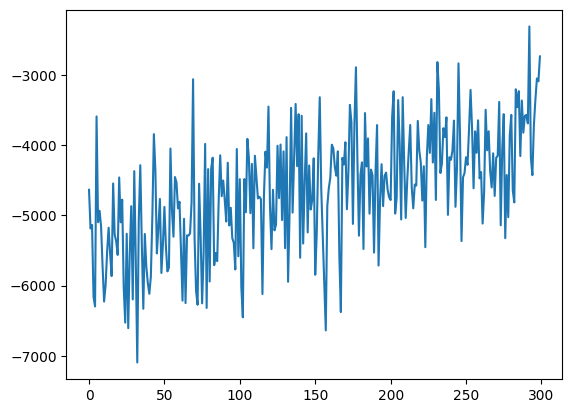

In [12]:
chunk_size = 10
y_points = np.array([])
for chunk in range(num_of_episodes // chunk_size):
    avg = np.sum(agent_rewards[chunk * chunk_size: chunk * chunk_size + chunk_size]) / chunk_size
    y_points = np.append(y_points, avg)
x_points = np.arange(0, num_of_episodes // chunk_size)
plt.plot(x_points, y_points)
# plt.savefig(f'{project_dir}/results108.png')
plt.show()